Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset preview:
            Start Date        End Date Charging Time (hh:mm:ss)  Energy (kWh)  \
0  2020-01-01 09:11:00  1/1/2020 11:20                  2:08:25        12.885   
1  2020-01-01 09:32:00  1/1/2020 11:19                  1:47:06         5.936   
2  2020-01-01 09:44:00  1/1/2020 10:57                  1:12:40         3.652   
3  2020-01-01 09:45:00  1/1/2020 10:45                  1:00:15         6.031   
4  2020-01-01 09:45:00  1/1/2020 15:08                  5:22:07        32.260   

  Port Type  Port Number Plug Type  
0   Level 2            2     J1772  
1   Level 2            2     J1772  
2   Level 2            2     J1772  
3   Level 2            1     J1772  
4   Level 2            1     J1772  

Data Split:
Training samples: 14067
Validation samples: 3015
Test samples: 3015
[0]	validation_0-rmse:9.17630
[1]	validation_0-rmse:9.09713
[2]	

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 64)                  │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,753 (10.75 KB)

 Trainable params: 2,753 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 6.7774 - mae: 2.0153 - val_loss: 10.7597 - val_mae: 2.2532
Epoch 2/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 6.5636 - mae: 1.9841 - val_loss: 10.7920 - val_mae: 2.2630
Epoch 3/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 6.3707 - mae: 1.9544 - val_loss: 10.7918 - val_mae: 2.2630
Epoch 4/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.5972 - mae: 1.9840 - val_loss: 10.7934 - val_mae: 2.2555
Epoch 5/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.6107 - mae: 1.9749 - val_loss: 10.7892 - val_mae: 2.2592
Epoch 6/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.7407 - mae: 1.9953 - val_loss: 10.7647 - val_mae: 2.2558
Epoch 7/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.7317 - mae: 2.0022 - val_loss: 10.7890 - val_mae: 2.2514
Epoch 8/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.7166 - mae: 1.9665 - val_loss: 10.7760 - val_mae: 2.2585
Epoch 9/100
440/440 ━━━━━━━━━━━━━━━━━━━━

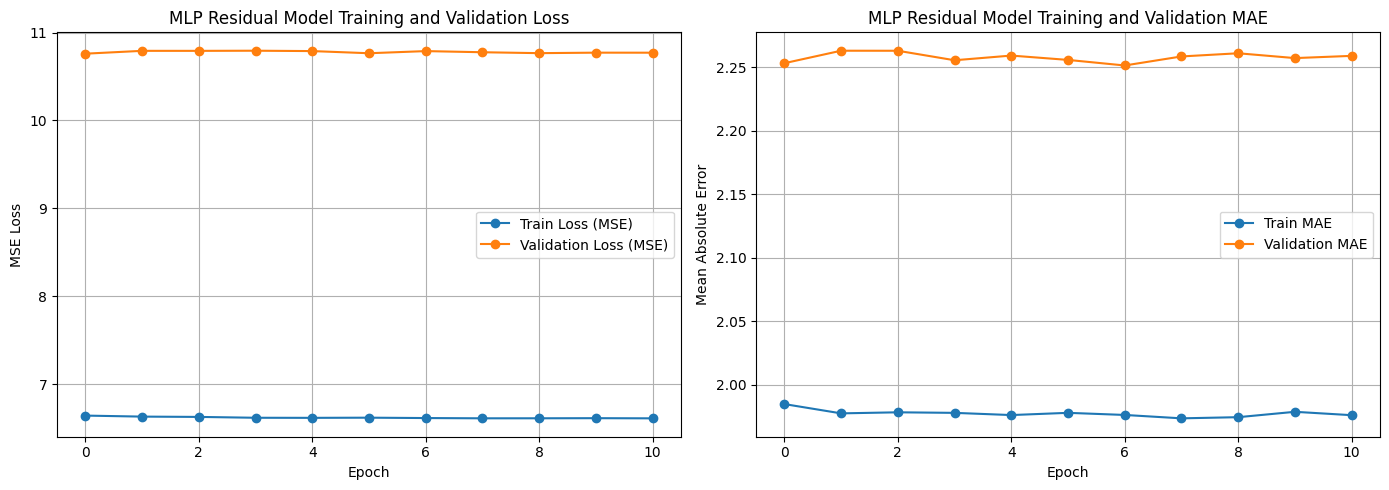

In [ ]:
# Stacking Ensemble: XGBoost + MLP on Residual Errors V1

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------
# 1. Mount Google Drive & Load Data
# ---------------------------
from google.colab import drive
drive.mount('/content/drive')

file_path = "/content/drive/My Drive/Colab Notebooks/Data/2020_Data_V0.1.csv"
df = pd.read_csv(file_path)
print("Dataset preview:")
print(df.head())

# ---------------------------
# 2. Data Preprocessing & Feature Engineering
# ---------------------------
# Function to convert time strings to total seconds.
def convert_to_seconds(time_str):
    h, m, s = map(int, time_str.split(':'))
    return h * 3600 + m * 60 + s

df['Charging Time (seconds)'] = df['Charging Time (hh:mm:ss)'].apply(convert_to_seconds)

# Process 'Start Date' into datetime and extract time-related features.
df['Start Date'] = pd.to_datetime(df['Start Date'])
df['Start Hour'] = df['Start Date'].dt.hour
df['Start Day'] = df['Start Date'].dt.day
df['Start Month'] = df['Start Date'].dt.month

# Create Charging Duration Categories based on total seconds.
df['Charging Duration Category'] = pd.cut(
    df['Charging Time (seconds)'],
    bins=[0, 1800, 3600, 7200, 14400, np.inf],
    labels=['<30min', '30min-1hr', '1-2hr', '2-4hr', '>4hr']
)

# One-hot encode categorical features: 'Port Type' and 'Charging Duration Category'.
df = pd.get_dummies(df, columns=['Port Type', 'Charging Duration Category'], drop_first=True)

# Define the list of features: numeric features + one-hot encoded features.
numeric_features = ['Charging Time (seconds)', 'Start Hour', 'Start Day', 'Start Month']
one_hot_features = [col for col in df.columns if col.startswith('Port Type_') or col.startswith('Charging Duration Category_')]
features = numeric_features + one_hot_features

X = df[features]
y = df['Energy (kWh)']

# ---------------------------
# 3. Normalize Features and Split Data
# ---------------------------
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

from sklearn.model_selection import train_test_split
# Split into training (70%), validation (15%), and test (15%) sets.
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test     = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("\nData Split:")
print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

# ---------------------------
# 4. Train an XGBoost Model to Capture Feature Interactions
# ---------------------------
import xgboost as xgb

# Set up the XGBoost regressor.
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=6,
    random_state=42
)

# Train XGBoost using early stopping on the validation set.
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)


# Get predictions on the training and validation sets.
y_train_pred_xgb = xgb_model.predict(X_train)
y_val_pred_xgb   = xgb_model.predict(X_val)

# Compute residual errors for training and validation.
residual_train = y_train - y_train_pred_xgb
residual_val   = y_val - y_val_pred_xgb

# ---------------------------
# 5. Train an MLP to Refine Predictions on Residual Errors
# ---------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Build a simple MLP model.
mlp_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

mlp_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
mlp_model.summary()

# Train the MLP on the residuals.
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_mlp = mlp_model.fit(
    X_train, residual_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, residual_val),
    callbacks=[early_stop],
    verbose=1
)

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# ------------------------------------------------------------
# 8. Evaluate Ensemble Performance on Training, Validation, and Test Sets
# ------------------------------------------------------------
# Generate final ensemble predictions:
# (XGBoost prediction + MLP residual prediction)
# Note: The MLP model returns predictions with shape (n_samples, 1), so we flatten them.
y_train_pred_final = xgb_model.predict(X_train) + mlp_model.predict(X_train).flatten()
y_val_pred_final   = xgb_model.predict(X_val)   + mlp_model.predict(X_val).flatten()
y_test_pred_final  = xgb_model.predict(X_test)  + mlp_model.predict(X_test).flatten()

# Compute MSE directly for each set (since our ensemble is a combination of two models)
train_mse = mean_squared_error(y_train, y_train_pred_final)
val_mse   = mean_squared_error(y_val, y_val_pred_final)
test_mse  = mean_squared_error(y_test, y_test_pred_final)

print("\nStacking Ensemble (XGBoost + MLP on Residuals) Performance (Computed Metrics):")
print(f"Training MSE: {train_mse:.3f}")
print(f"Validation MSE: {val_mse:.3f}")
print(f"Test MSE: {test_mse:.3f}")

# Helper function to compute and print additional metrics.
def print_metrics(y_true, y_pred, set_name="Dataset"):
    r2   = r2_score(y_true, y_pred)
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    print(f"\n{set_name} Metrics:")
    print(f"R² Score: {r2:.3f}")
    print(f"MSE: {mse:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"MAE: {mae:.3f}")

print_metrics(y_train, y_train_pred_final, "Training")
print_metrics(y_val, y_val_pred_final, "Validation")
print_metrics(y_test, y_test_pred_final, "Test")

# ------------------------------------------------------------
# 9. Plot the MLP Training History for Residual Learning
# ------------------------------------------------------------
plt.figure(figsize=(14, 5))

# Plot Loss (MSE) over epochs.
plt.subplot(1, 2, 1)
plt.plot(history_mlp.history['loss'], label='Train Loss (MSE)', marker='o')
plt.plot(history_mlp.history['val_loss'], label='Validation Loss (MSE)', marker='o')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('MLP Residual Model Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot MAE over epochs.
plt.subplot(1, 2, 2)
plt.plot(history_mlp.history['mae'], label='Train MAE', marker='o')
plt.plot(history_mlp.history['val_mae'], label='Validation MAE', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('MLP Residual Model Training and Validation MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset preview:
            Start Date        End Date Charging Time (hh:mm:ss)  Energy (kWh)  \
0  2020-01-01 09:11:00  1/1/2020 11:20                  2:08:25        12.885   
1  2020-01-01 09:32:00  1/1/2020 11:19                  1:47:06         5.936   
2  2020-01-01 09:44:00  1/1/2020 10:57                  1:12:40         3.652   
3  2020-01-01 09:45:00  1/1/2020 10:45                  1:00:15         6.031   
4  2020-01-01 09:45:00  1/1/2020 15:08                  5:22:07        32.260   

  Port Type  Port Number Plug Type  
0   Level 2            2     J1772  
1   Level 2            2     J1772  
2   Level 2            2     J1772  
3   Level 2            1     J1772  
4   Level 2            1     J1772  

Data Split:
Training samples: 14067
Validation samples: 3015
Test samples: 3015
XGBoost version: 2.1.3
[0]	validation_0-rmse:9.17560
[1]	validat

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 128)                 │           1,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,545 (49.00 KB)

 Trainable params: 12,161 (47.50 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/150
440/440 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 7.4163 - mae: 2.0698 - val_loss: 10.6772 - val_mae: 2.2771 - learning_rate: 0.0010
Epoch 2/150
440/440 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.5034 - mae: 1.9574 - val_loss: 10.7789 - val_mae: 2.3104 - learning_rate: 0.0010
Epoch 3/150
440/440 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 6.2207 - mae: 1.9263 - val_loss: 10.7261 - val_mae: 2.2889 - learning_rate: 0.0010
Epoch 4/150
440/440 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.3936 - mae: 1.9545 - val_loss: 10.7296 - val_mae: 2.2976 - learning_rate: 0.0010
Epoch 5/150
440/440 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 6.2246 - mae: 1.9301 - val_loss: 10.6645 - val_mae: 2.2705 - learning_rate: 0.0010
Epoch 6/150
440/440 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 6.0021 - mae: 1.8902 - val_loss: 10.7317 - val_mae: 2.2906 - learning_rate: 0.0010
Epoch 7/150
440/440 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.2430 - mae: 1.9363 - val_loss: 10.6511 - val_mae: 2.2682 - learning_rate

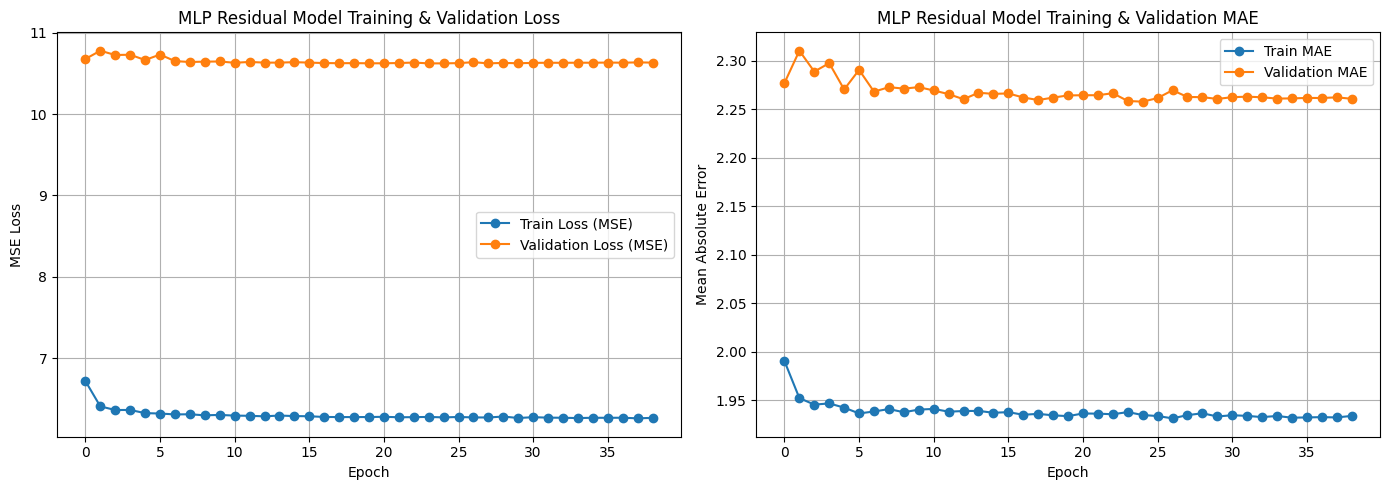

In [ ]:
# Improved Stacking Ensemble: XGBoost + MLP on Residuals V2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# ---------------------------------------------------
# 1. Mount Google Drive & Load Data
# ---------------------------------------------------
from google.colab import drive
drive.mount('/content/drive')

file_path = "/content/drive/My Drive/Colab Notebooks/Data/2020_Data_V0.1.csv"
df = pd.read_csv(file_path)
print("Dataset preview:")
print(df.head())

# ---------------------------------------------------
# 2. Data Preprocessing & Feature Engineering
# ---------------------------------------------------
def convert_to_seconds(time_str):
    h, m, s = map(int, time_str.split(':'))
    return h * 3600 + m * 60 + s

df['Charging Time (seconds)'] = df['Charging Time (hh:mm:ss)'].apply(convert_to_seconds)
df['Start Date'] = pd.to_datetime(df['Start Date'])
df['Start Hour'] = df['Start Date'].dt.hour
df['Start Day'] = df['Start Date'].dt.day
df['Start Month'] = df['Start Date'].dt.month
# NEW: Added day of week as an additional time-based feature.
df['Start DayOfWeek'] = df['Start Date'].dt.dayofweek

df['Charging Duration Category'] = pd.cut(
    df['Charging Time (seconds)'],
    bins=[0, 1800, 3600, 7200, 14400, np.inf],
    labels=['<30min', '30min-1hr', '1-2hr', '2-4hr', '>4hr']
)

# One-hot encode categorical features.
df = pd.get_dummies(df, columns=['Port Type', 'Charging Duration Category'], drop_first=True)

numeric_features = ['Charging Time (seconds)', 'Start Hour', 'Start Day', 'Start Month', 'Start DayOfWeek']
one_hot_features = [col for col in df.columns if col.startswith('Port Type_') or col.startswith('Charging Duration Category_')]
features = numeric_features + one_hot_features

X = df[features]
y = df['Energy (kWh)']

# ---------------------------------------------------
# 3. Normalize Features and Split Data
# ---------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test     = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("\nData Split:")
print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

# ---------------------------------------------------
# 4. Train an Enhanced XGBoost Model
# ---------------------------------------------------
# Check XGBoost version
print("XGBoost version:", xgb.__version__)

# Improvements: Added subsample, colsample_bytree, and regularization parameters.
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42
)

# Note: early_stopping_rounds is removed to avoid the TypeError.
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)

# Obtain predictions and compute residuals.
y_train_pred_xgb = xgb_model.predict(X_train)
y_val_pred_xgb   = xgb_model.predict(X_val)

residual_train = y_train - y_train_pred_xgb
residual_val   = y_val - y_val_pred_xgb

# ---------------------------------------------------
# 5. Train an Improved MLP on Residual Errors
# ---------------------------------------------------
mlp_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

mlp_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mse',
                  metrics=['mae'])
mlp_model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
reduce_lr  = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history_mlp = mlp_model.fit(
    X_train, residual_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_val, residual_val),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# ---------------------------------------------------
# 6. Evaluate the Stacking Ensemble
# ---------------------------------------------------
# Final prediction: XGBoost prediction + MLP residual correction.
y_train_pred_final = xgb_model.predict(X_train) + mlp_model.predict(X_train).flatten()
y_val_pred_final   = xgb_model.predict(X_val)   + mlp_model.predict(X_val).flatten()
y_test_pred_final  = xgb_model.predict(X_test)  + mlp_model.predict(X_test).flatten()

def print_metrics(y_true, y_pred, set_name="Dataset"):
    r2   = r2_score(y_true, y_pred)
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    print(f"\n{set_name} Metrics:")
    print(f"R² Score: {r2:.3f}")
    print(f"MSE: {mse:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"MAE: {mae:.3f}")

print("\nStacking Ensemble (XGBoost + MLP on Residuals) Performance:")
print_metrics(y_train, y_train_pred_final, "Training")
print_metrics(y_val, y_val_pred_final, "Validation")
print_metrics(y_test, y_test_pred_final, "Test")

# ---------------------------------------------------
# 7. Plot the MLP Training History
# ---------------------------------------------------
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_mlp.history['loss'], label='Train Loss (MSE)', marker='o')
plt.plot(history_mlp.history['val_loss'], label='Validation Loss (MSE)', marker='o')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('MLP Residual Model Training & Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_mlp.history['mae'], label='Train MAE', marker='o')
plt.plot(history_mlp.history['val_mae'], label='Validation MAE', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('MLP Residual Model Training & Validation MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
aaaa